In [ ]:
#default_exp data.transform

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.notebook.showdoc import show_doc

from types import MethodType

# Transforms

## Helpers

In [ ]:
#export
def anno_ret(func):
    "Get the return annotation of `func`"
    ann = typing.get_type_hints(func)
    if not ann: return None
    typ = ann.get('return')
    return list(typ.__args__) if getattr(typ, '_name', '')=='Tuple' else typ

In [ ]:
#hide
def f(x) -> float: return x
test_eq(anno_ret(f), float)
def f(x) -> Tuple[float,float]: return x
test_eq(anno_ret(f), [float,float])
def f(x) -> None: return x
test_eq(anno_ret(f), NoneType)
def f(x): return x
test_eq(anno_ret(f), None)

In [ ]:
#export
cmp_instance = functools.cmp_to_key(lambda a,b: 0 if a==b else 1 if issubclass(a,b) else -1)

In [ ]:
td = {int:1, numbers.Number:2, numbers.Integral:3}
test_eq(sorted(td, key=cmp_instance), [numbers.Number, numbers.Integral, int])

In [ ]:
#export
def _p1_anno(f):
    "Get the annotation of first param of `f`"
    ann = [o for n,o in typing.get_type_hints(f).items() if n!='return']
    return ann[0] if ann else object

In [ ]:
def _f(a, b): pass
test_eq(_p1_anno(_f), object)
def _f(a, b)->str: pass
test_eq(_p1_anno(_f), object)
def _f(a, b:str)->float: pass
test_eq(_p1_anno(_f), str)
def _f(a:int, b:int)->float: pass
test_eq(_p1_anno(_f), int)

## Types

In [ ]:
#export
class ShowTitle:
    "Base class that adds a simple `show`"
    def show(self, ctx=None, **kwargs): return show_title(str(self), ctx=ctx)

class Int(int, ShowTitle): pass
class Float(float, ShowTitle): pass
class Str(str, ShowTitle): pass
add_docs(Int, "An `int` with `show`"); add_docs(Str, "An `str` with `show`"); add_docs(Float, "An `float` with `show`")

In [ ]:
show_doc(Int, title_level=3)

<h3 id="<code>class</code> <code>Int</code>" class="doc_header"><code>class</code> <code>Int</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02_transforms.ipynb#Types" class="source_link" style="float:right">[source]</a></h3>

> <code>Int</code>() :: `int`

An `int` with `show`

In [ ]:
show_doc(Str, title_level=3)

<h3 id="<code>class</code> <code>Str</code>" class="doc_header"><code>class</code> <code>Str</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02_transforms.ipynb#Types" class="source_link" style="float:right">[source]</a></h3>

> <code>Str</code>() :: `str`

An `str` with `show`

In [ ]:
show_doc(Float, title_level=3)

<h3 id="<code>class</code> <code>Float</code>" class="doc_header"><code>class</code> <code>Float</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02_transforms.ipynb#Types" class="source_link" style="float:right">[source]</a></h3>

> <code>Float</code>(**`x`**=*`0`*) :: `float`

An `float` with `show`

In [ ]:
test_stdout(lambda: Str('s').show(), 's')
test_stdout(lambda: Int(1).show(), '1')

In [ ]:
#export
class TensorBase(Tensor):
    def __new__(cls, x, *args, **kwargs):
        x = cls._cast(tensor(x))
        x._cls = cls
        x.show = MethodType(partial(cls.show, show_args=cls._show_args), x)
        return x

    @classmethod
    def _cast(cls, x): return x.float()

class TensorImage(TensorBase):
    _show_args = {'cmap':'viridis'}
    def show(self, ctx=None, show_args=None, **kwargs): return show_image(self, ctx=ctx, **{**show_args, **kwargs})
    
class FloatTensorImage(TensorImage): pass

class ByteTensorImage (TensorImage):
    @classmethod
    def _cast(cls, x): return x.byte()

class ByteTensorMask(TensorImage):
    _show_args = {'alpha':0.5, 'cmap':'tab20'}
    @classmethod
    def _cast(cls, x): return x.byte()
    
class LongTensorMask(TensorImage): 
    _show_args = {'alpha':0.5, 'cmap':'tab20'}
    @classmethod
    def _cast(cls, x): return x.long()

In [ ]:
#TODO show docs

In [ ]:
im = PIL.Image.open(TEST_IMAGE).resize((128,128))
im_a = array(im)
im_bt = ByteTensorImage(im_a)
im_bt.shape, im_bt.type(), im_bt._cls

(torch.Size([128, 128, 3]), 'torch.ByteTensor', __main__.ByteTensorImage)

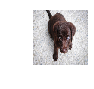

In [ ]:
im_bt.show(figsize=(1,1));

In [ ]:
#export
def type_ex(x):
    "Type of `x`, using `_cls` if available"
    if not (isinstance(x,Tensor) and hasattr(x,'_cls')): return type(x)
    return x._cls

In [ ]:
test_eq(type_ex(3), int)
test_eq(type_ex(tensor(1)), Tensor)
test_eq(type_ex(im_bt), ByteTensorImage)

In [ ]:
#export
def load_image(fn, *args, **kwargs):
    im = PIL.Image.open(fn, *args, **kwargs)
    im.load()
    return im._new(im.im)

In [ ]:
#export
class PILBase(PIL.Image.Image):
    def __new__(cls, x, *args, **kwargs):
        if not isinstance(x,PIL.Image.Image): return super().__new__(cls)
        x.__class__ = cls
        return x
    
    def __init__(self, x=None):
        if not isinstance(x,PIL.Image.Image): return super().__init__()
        
    @classmethod
    def open(cls, fn, *args, **kwargs): return cls(load_image(fn, *args, **kwargs))

In [ ]:
#export
class PILImage(PILBase): pass

In [ ]:
#export
class PILMask(PILBase): pass

In [ ]:
im = PILImage.open(TEST_IMAGE)
test_eq(type(im), PILImage)

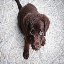

In [ ]:
im.resize((64,64))

In [ ]:
im = PILMask.open(TEST_IMAGE)
test_eq(type(im), PILMask)

In [ ]:
class TensorBase(Tensor):
    def __new__(cls, x, *args, **kwargs):
        if not isinstance(x,Tensor): return super().__new__(cls)
        x.__class__ = cls
        return x
    
    def __init__(self, *args, **kwargs):
        if not (args and isinstance(args[0],Tensor)): return super().__init__(*args, **kwargs)
    
class TensorImage(TensorBase): pass
class TensorMask(TensorBase): pass

In [ ]:
t = tensor([2.,1])

In [ ]:
t2 = TensorImage(t)

In [ ]:
isinstance(t2, TensorImage)

True

## Transform -

In [ ]:
#export
class TypeDispatch:
    "Dictionary-like object; `__getitem__` matches keys of types using `issubclass`"
    def __init__(self, *funcs):
        self.funcs,self.cache = {},{}
        for f in funcs: self.add(f)
        
    def _reset(self):
        self.funcs = {k:self.funcs[k] for k in sorted(self.funcs, key=cmp_instance, reverse=True)}
        self.cache = {**self.funcs}
        
    def add(self, f):
        "Add type `t` and function `f`"
        self.funcs[_p1_anno(f) or object] = f
        self._reset()
        
    def __repr__(self): return str({getattr(k,'__name__',str(k)):v.__name__ for k,v in self.funcs.items()})
    def __getitem__(self, k):
        "Find first matching type that is a super-class of `k`"
        if k in self.cache: return self.cache[k]
        types = [f for f in self.funcs if issubclass(k,f)]
        res = self.funcs[types[0]] if types else None
        self.cache[k] = res
        return res

In [ ]:
def f_col(x:typing.Collection): pass
def f_nin(x:numbers.Integral): pass
def f_bti(x:ByteTensorImage): pass
def f_fti(x:FloatTensorImage): pass
def f_flt(x:bool): pass
def f_num(x:numbers.Number): pass
t = TypeDispatch(f_nin,f_fti,f_num,f_bti,f_flt)

test_eq(t[int], f_nin)
test_eq(t[str], None)
test_eq(t[FloatTensorImage], f_fti)
test_eq(t[float], f_num)
t.add(f_col)
test_eq(t[str], f_col)
test_eq(t[int], f_nin)
t

{'ByteTensorImage': 'f_bti', 'FloatTensorImage': 'f_fti', 'typing.Collection': 'f_col', 'bool': 'f_flt', 'Integral': 'f_nin', 'Number': 'f_num'}

In [ ]:
#export
class TfmMeta(type):
    def __new__(cls, name, bases, dct):
        res = super().__new__(cls, name, bases, dct)
        res.fs = (TypeDispatch(),TypeDispatch())
        if hasattr(res,'encodes'): res.fs[True ].add(res.encodes)
        if hasattr(res,'decodes'): res.fs[False].add(res.decodes)
        return res

    def __call__(cls, *args, **kwargs):
        f = args[0] if args else None
        if isinstance(f,Callable) and f.__name__ in ('decode','encode','_'):
            d = cls.fs[f.__name__ != 'decode']
            d.add(f)
            return f
        return super().__call__(*args, **kwargs)

In [ ]:
#export
class Transform(metaclass=TfmMeta):
    "Delegates (`__call__`,`decode`) to (`encodes`,`decodes`) if `filt` matches"
    filt,init_enc,as_item_force,as_item = None,False,None,True
    def __init__(self, enc=None, dec=None, filt=None, as_item=True):
        self.filt,self.as_item = ifnone(filt, self.filt),as_item
        self.init_enc = enc or dec
        if not self.init_enc: return
        self.fs = (TypeDispatch(),TypeDispatch())
        if enc: self.fs[True] .add(enc)
        if dec: self.fs[False].add(dec)

    @property
    def use_as_item(self): return ifnone(self.as_item_force, self.as_item)
    def __call__(self, x, **kwargs): return self.call(True,  x, **kwargs)
    def decode  (self, x, **kwargs): return self.call(False, x, **kwargs)
    def __repr__(self): return f'{self.use_as_item} {self.fs}'
    
    def call(self, is_enc, x, filt=None, **kwargs):
        if filt!=self.filt and self.filt is not None: return x
        f = self.func(is_enc, x)
        if self.use_as_item: return self._do_call(f, x, **kwargs)
        return tuple(self._do_call(f_, x_, **kwargs) for f_,x_ in zip(f,x))

    def lookup(self, is_enc, x):
        f = self.fs[is_enc][type_ex(x)]
        return (f or noop) if self.init_enc else MethodType(f or noops, self)
    
    def func(self, is_enc, x, filt=None):
        if self.use_as_item: return self.lookup(is_enc,x)
        return [self.lookup(is_enc,x_) for x_ in x]

    def _do_call(self, f, x, **kwargs):
        if f is None: return x
        res = f(x, **kwargs)
        typ_r = ifnone(anno_ret(f), type_ex(x))
        return typ_r(res) if typ_r!=NoneType and not isinstance(res, typ_r) else res

Base class that delegates `__call__` and `decode` to `encodes` and `decodes`, doing nothing if param annotation doesn't match type. If called with listy `x` then it calls function with each item (unless `whole_typle`, in which case it's passed directly as a whole). The function (if matching 1st param type) will cast the result to the same as the input type, unless there's a return annotation (in which case it's cast to that), or the return annotation is `None` (in which case no casting is done).

Details: `Transform` is a base class where you override encodes and/or decodes. e.g. `__call__` uses `call` which looks up what to call using `func`. If `whole_tuple` is set, that just returns `encodes` (or `decodes` if not `is_enc`). Otherwise we find the first annotated param with `_p1_anno` and check if `x` is an instance of that (if not `is_listy(x)`). If it is, we return the function (encodes/decodes), otherwise None. `call` then passes on to `_do_call` which does nothing if function is `None`. If `x` is listy, then we return a *list* of {functions or `None`}, and a list of results from `_do_call` for each function is returned.

In [ ]:
class A(Transform): pass
f = A()
test_eq_type(f(2), 2)
test_eq_type(f.decode(2.0), 2.0)

Return annotation is used to ensure we get an `Int`. Since `decodes` doesn't exist, `decode` does nothing.

In [ ]:
class A(Transform):
    def encodes(self, x)->Int: return x/2
    
f = A()
test_eq_type(f(2), Int(1))
test_eq_type(f.decode(2.0), 2.0)

`Transform` will not convert a subclass to a superclass type. For 

In [ ]:
class A(Transform):
    def encodes(self, x)->PILImage: return x

im = load_image(TEST_IMAGE)
f = A()
t = f(im)
test_eq(t, im)
test_eq(type(t), PILImage)

In [ ]:
class A(Transform):
    def encodes(self, x:ByteTensorImage): return -x
    
f = A()
t = f(im_bt)
test_eq(t, -im_bt)
test_eq(type_ex(t), ByteTensorImage)

Without return annotation we get an `Int` back since that's what was passed.

In [ ]:
class A(Transform):
    def encodes(self, x): return x/2
    
f = A()
test_eq_type(f(Int(2)), Int(1))
test_eq_type(f(2), 1)

With return annotation `None` we get back whatever Python creates usually.

In [ ]:
class A(Transform):
    def encodes(self, x)->None: return x/2
    
f = A()
test_eq_type(f(2), 1.)
test_eq_type(f(2.), 1.)

Since `decodes` has no return annotation, but `encodes` created an `Int` and we pass that result here to `decode`, we end up with an `Int`.

In [ ]:
class A(Transform): 
    def encodes(self, x)->Int: return x+1
    def decodes(self, x): return x-1

f = A()
t = f(1)
test_eq_type(t, Int(2))
test_eq_type(f.decode(t), Int(1))

If the transform has `filt` then it's only applied if `filt` param matches.

In [ ]:
f.filt = 1
test_eq(f(1, filt=1),2)
test_eq_type(f(1, filt=0), 1)

In [ ]:
class A(Transform): 
    def encodes(self, xy): x,y=xy; return (x+y,y)
    def decodes(self, xy): x,y=xy; return (x-y,y)

f = A()
t = f((1,2))
test_eq(t, (3,2))
test_eq(f.decode(t), (1,2))
f.filt = 1
test_eq(f((1,2), filt=1), (3,2))
test_eq(f((1,2), filt=0), (1,2))

In [ ]:
class AL(Transform): 
    def encodes(self, x): return L(x_+1 for x_ in x)
    def decodes(self, x): return L(x_-1 for x_ in x)

f = AL()
t = f([1,2])
test_eq(t, [2,3])
test_eq(f.decode(t), [1,2])

## TupleTransform

In [ ]:
def neg_int(x:numbers.Integral): return -x

f = Transform(neg_int, as_item=False)
test_eq(f([1]), (-1,))
test_eq(f([1.]), (1.,))
test_eq(f([1.,2,3.]), (1.,-2,3.))
test_eq(f.decode([1,2]), (1,2))

In [ ]:
#export
class TupleTransform(Transform):
    "`Transform` that always treats `as_item` as `False`"
    as_item_force=False

In [ ]:
#export
class ItemTransform (Transform):
    "`Transform` that always treats `as_item` as `True`"
    as_item_force=True

In [ ]:
def float_to_int(x:(float,int))->Int: return x

f = TupleTransform(float_to_int)
test_eq_type(f([1.]), (Int(1),))
test_eq_type(f([1]), (Int(1),))
test_eq_type(f(['1']), ('1',))
test_eq_type(f([1,'1']), (Int(1),'1'))
test_eq(f.decode([1]), [1])

In [ ]:
class B(TupleTransform): pass
class C(TupleTransform): pass
f = B()
test_eq(f([1]), [1])

In [ ]:
@B
def _(self, x:int): return x+1
@B
def _(self, x:str): return x+'1'
@B
def _(self, x)->None: return str(x)+'!'

b,c = B(),C()
test_eq(b([1]), [2])
test_eq(b(['1']), ('11',))
test_eq(b([1.0]), ('1.0!',))
test_eq(c([1]), [1])
test_eq(b([1,2]), (2,3))
test_eq(b.decode([2]), [2])
assert pickle.loads(pickle.dumps(b))

In [ ]:
@B
def decode(self, x:int): return x-1
test_eq(b.decode([2]), [1])
test_eq(b.decode(('2',)), ('2',))

Non-type-constrained functions are applied to all elements of a tuple.

In [ ]:
class A(TupleTransform): pass
@A
def _(self, x): return x+1
@A
def decode(self, x): return x-1

f = A()
t = f((1,2.0))
test_eq_type(t, (2,3.0))
test_eq_type(f.decode(t), (1,2.0))

Type-constrained functions are applied to only matching elements of a tuple, and return annotations are only applied where matching.

In [ ]:
class B(TupleTransform): pass
@B
def _(self, x:int)->Int: return x+1
@B
def _(self, x:str): return x+'1'
@B
def decode(self, x:Int): return x/2

f = B()
start = (1.,2,'3')
t = f(start)
test_eq_type(t, (1.,Int(3),'31'))
test_eq(f.decode(t), (1.,Int(1),'31'))

The same behavior also works with `typing` module type classes.

In [ ]:
class A(Transform): pass
@A
def _(self, x:numbers.Integral): return x+1
@A
def _(self, x:float): return x*3
@A
def decode(self, x:int): return x-1

f = A()
start = 1.0
t = f(start)
test_eq(t, 3.)
test_eq(f.decode(t), 3)

f = A(as_item=False)
start = (1.,2,3.)
t = f(start)
test_eq(t, (3.,3,9.))
test_eq(f.decode(t), (3.,2,9.))

Transform accepts lists

In [ ]:
def a(x): return L(x_+1 for x_ in x)
def b(x): return L(x_-1 for x_ in x)
f = TupleTransform(a,b)

t = f((L(1,2),))
test_eq(t, (L(2,3),))
test_eq(f.decode(t), (L(1,2),))

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 02_transforms.ipynb.
Converted 02a_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial-meta.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_vision_augment.ipynb.
Converted 09_data_block.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 16_callback_tracker.ipynb.
Converted 17_callback_fp16.ipynb.
Converted 30_text_core.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
